In [15]:
# House Price Prediction - Advanced Regression Techniques

# Importing all the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Setting up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfylly!")


Libraries imported successfylly!


In [16]:
try:
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    print("Data loaded successfully!")
    print(f"Training data shape:{train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
except FileNotFoundError:
    print("Error: Make sure your CSV files are in the 'HousePricePrediction")
    print(f"Error loading data: {e}")
    print("Available files in current directory:")
    for item in os.listdir('.'):
        print(f"  - {item}")


Data loaded successfully!
Training data shape:(1460, 81)
Test data shape: (1459, 80)


In [17]:

print("\n" + "="*50)
print("INITIAL DATA EXPLORATION")
print("="*50)

# Display basic information about the dataset
print("\n1. First 5 rows of training data:")
print(train_data.head())

print("\n2. Dataset Info:")
print(f"Number of features: {train_data.shape[1]}")
print(f"Number of samples: {train_data.shape[0]}")

print("\n3. Target variable (SalePrice) statistics:")
print(train_data['SalePrice'].describe())

print("\n4. Data types:")
print(train_data.dtypes.value_counts())



INITIAL DATA EXPLORATION

1. First 5 rows of training data:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSol


TARGET VARIABLE ANALYSIS


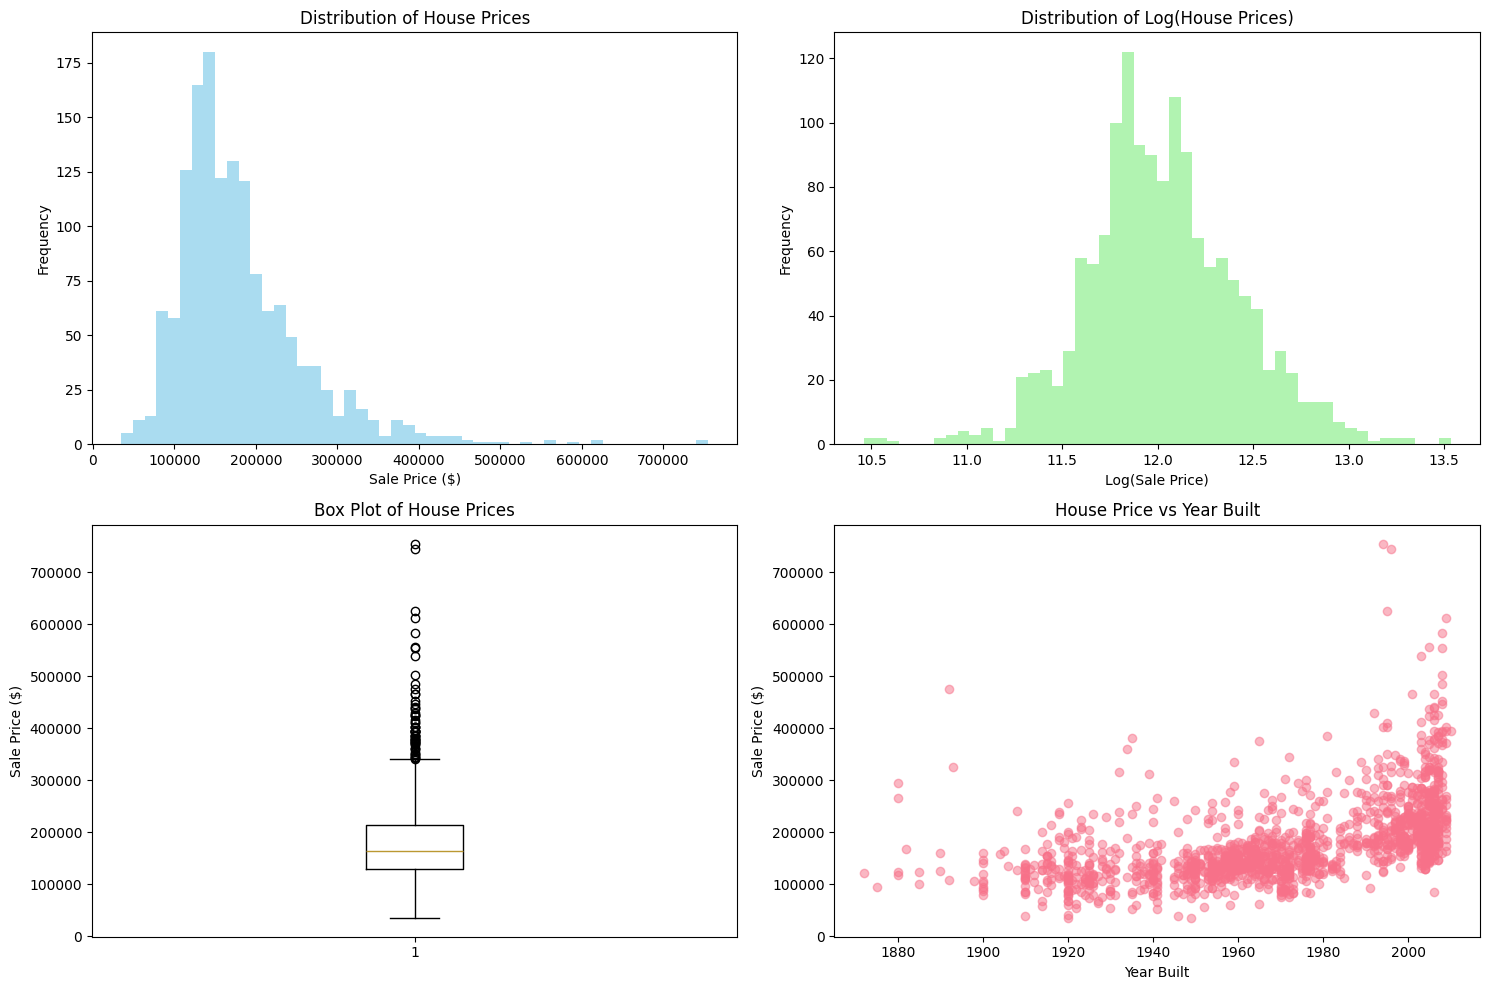

In [18]:
# Visualizing the data

print("\n" + "="*50)
print("TARGET VARIABLE ANALYSIS")
print("="*50)

# Create subplots for target variable analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of house prices
axes[0, 0].hist(train_data['SalePrice'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribution of House Prices')
axes[0, 0].set_xlabel('Sale Price ($)')
axes[0, 0].set_ylabel('Frequency')

# Log transformation of house prices
axes[0, 1].hist(np.log(train_data['SalePrice']), bins=50, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Distribution of Log(House Prices)')
axes[0, 1].set_xlabel('Log(Sale Price)')
axes[0, 1].set_ylabel('Frequency')

# Box plot
axes[1, 0].boxplot(train_data['SalePrice'])
axes[1, 0].set_title('Box Plot of House Prices')
axes[1, 0].set_ylabel('Sale Price ($)')

# Price vs Year Built
axes[1, 1].scatter(train_data['YearBuilt'], train_data['SalePrice'], alpha=0.5)
axes[1, 1].set_title('House Price vs Year Built')
axes[1, 1].set_xlabel('Year Built')
axes[1, 1].set_ylabel('Sale Price ($)')

plt.tight_layout()
plt.show()

In [19]:
# Identifying missing values

print("\n" + "="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)

def analyze_missing_values(df, dataset_name):
    """Analyze missing values in the dataset"""
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Column': missing_values.index,
        'Missing_Count': missing_values.values,
        'Missing_Percent': missing_percent.values
    })
    
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)
    
    print(f"\n{dataset_name} - Missing Values Summary:")
    print(missing_df.to_string(index=False))
    
    return missing_df

# Analyze missing values in both datasets
train_missing = analyze_missing_values(train_data, "TRAINING DATA")
test_missing = analyze_missing_values(test_data, "TEST DATA")

# =============================================================================
# STEP 6: DATA PREPROCESSING AND CLEANING
# =============================================================================

print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Combine train and test data for consistent preprocessing
# We'll separate them later
train_len = len(train_data)
combined_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

print(f"Combined dataset shape: {combined_data.shape}")


MISSING VALUES ANALYSIS

TRAINING DATA - Missing Values Summary:
      Column  Missing_Count  Missing_Percent
      PoolQC           1453        99.520548
 MiscFeature           1406        96.301370
       Alley           1369        93.767123
       Fence           1179        80.753425
  MasVnrType            872        59.726027
 FireplaceQu            690        47.260274
 LotFrontage            259        17.739726
  GarageType             81         5.547945
 GarageYrBlt             81         5.547945
GarageFinish             81         5.547945
  GarageQual             81         5.547945
  GarageCond             81         5.547945
BsmtExposure             38         2.602740
BsmtFinType2             38         2.602740
    BsmtQual             37         2.534247
    BsmtCond             37         2.534247
BsmtFinType1             37         2.534247
  MasVnrArea              8         0.547945
  Electrical              1         0.068493

TEST DATA - Missing Values Summar

In [20]:
# Handling missing values

def handle_missing_values(df):
    """Handle missing values based on data understanding"""
    
    print("Handling missing values...")
    
    # Categorical variables - fill with 'None' (meaning no feature)
    categorical_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
                       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                       'MasVnrType']
    
    for col in categorical_none:
        if col in df.columns:
            df[col] = df[col].fillna('None')
    
    # Numerical variables - fill with 0 (meaning no feature)
    numerical_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 
                     'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 
                     'BsmtHalfBath', 'MasVnrArea']
    
    for col in numerical_zero:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    # LotFrontage - fill with median of the neighborhood
    if 'LotFrontage' in df.columns:
        df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
            lambda x: x.fillna(x.median()))
    
    # Mode imputation for other categorical variables
    categorical_mode = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 
                       'SaleType', 'Functional', 'Electrical', 'KitchenQual']
    
    for col in categorical_mode:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0])
    
    return df

# Apply missing value handling
combined_data = handle_missing_values(combined_data)

# Check if missing values are handled
remaining_missing = combined_data.isnull().sum().sum()
print(f"Remaining missing values: {remaining_missing}")


Handling missing values...
Remaining missing values: 1459



FEATURE ENGINEERING
Creating new features...
New features created. Dataset shape: (2919, 92)

ENCODING CATEGORICAL VARIABLES
Encoding categorical variables...
Categorical columns to encode: 43
Categorical encoding completed. Dataset shape: (2919, 92)

FEATURE SCALING
Processed training data shape: (1460, 92)
Processed test data shape: (1459, 91)
Features scaled. Final feature set shape: (1460, 90)

FEATURE IMPORTANCE ANALYSIS
Top 20 most important features:
            feature  importance
79          TotalSF    0.441373
16      OverallQual    0.265199
89       PricePerSF    0.255718
18        YearBuilt    0.004615
80        TotalBath    0.003364
45        GrLivArea    0.003070
42         1stFlrSF    0.003030
43         2ndFlrSF    0.002611
37      TotalBsmtSF    0.002462
82         HouseAge    0.001892
25       MasVnrArea    0.001132
2       LotFrontage    0.000925
36        BsmtUnfSF    0.000798
61       GarageArea    0.000787
33       BsmtFinSF1    0.000732
48         FullBath    0.

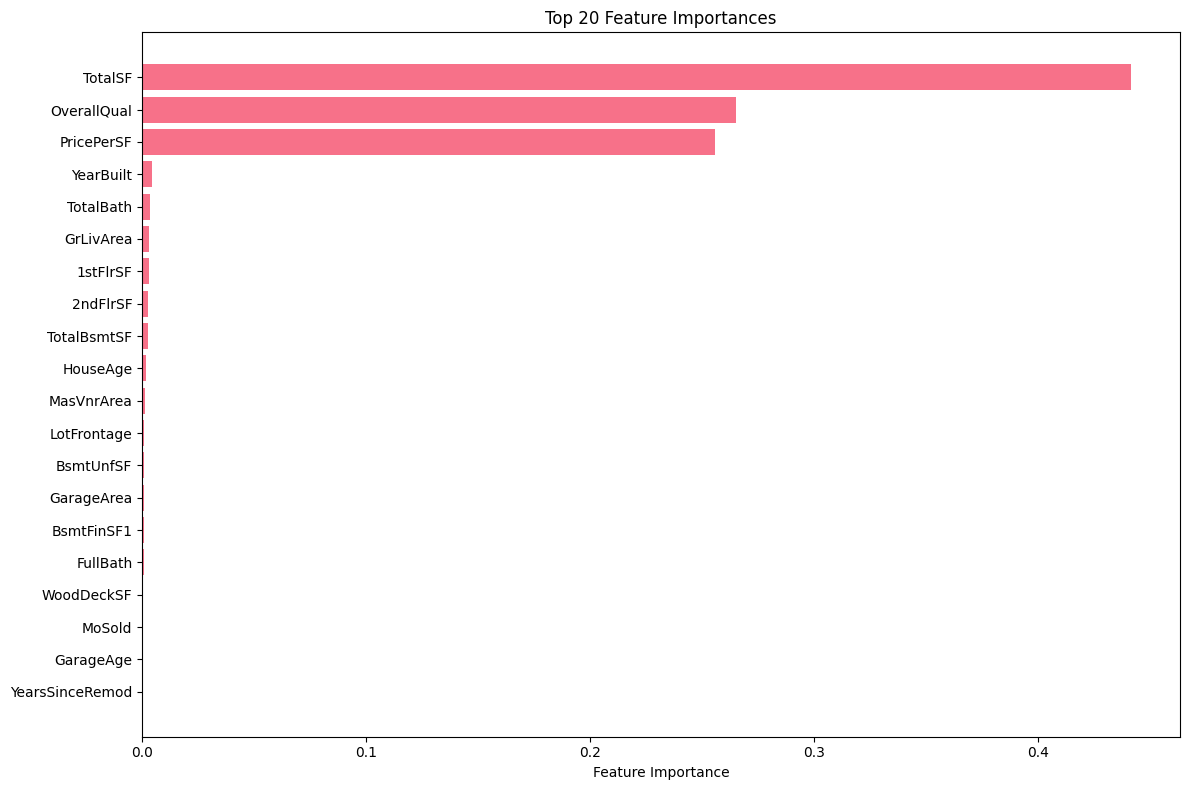


CORRELATION ANALYSIS
Features with high correlation (>0.5) with SalePrice:
SalePrice          1.000000
OverallQual        0.790982
TotalSF            0.782260
GrLivArea          0.708624
PricePerSF         0.640602
GarageCars         0.640409
TotalBath          0.631731
GarageArea         0.623431
TotalBsmtSF        0.613581
1stFlrSF           0.605852
FullBath           0.560664
TotRmsAbvGrd       0.533723
YearBuilt          0.522897
YearRemodAdd       0.507101
YearsSinceRemod   -0.509079
HouseAge          -0.523350
KitchenQual       -0.589189
BsmtQual          -0.593734
ExterQual         -0.636884
Name: SalePrice, dtype: float64


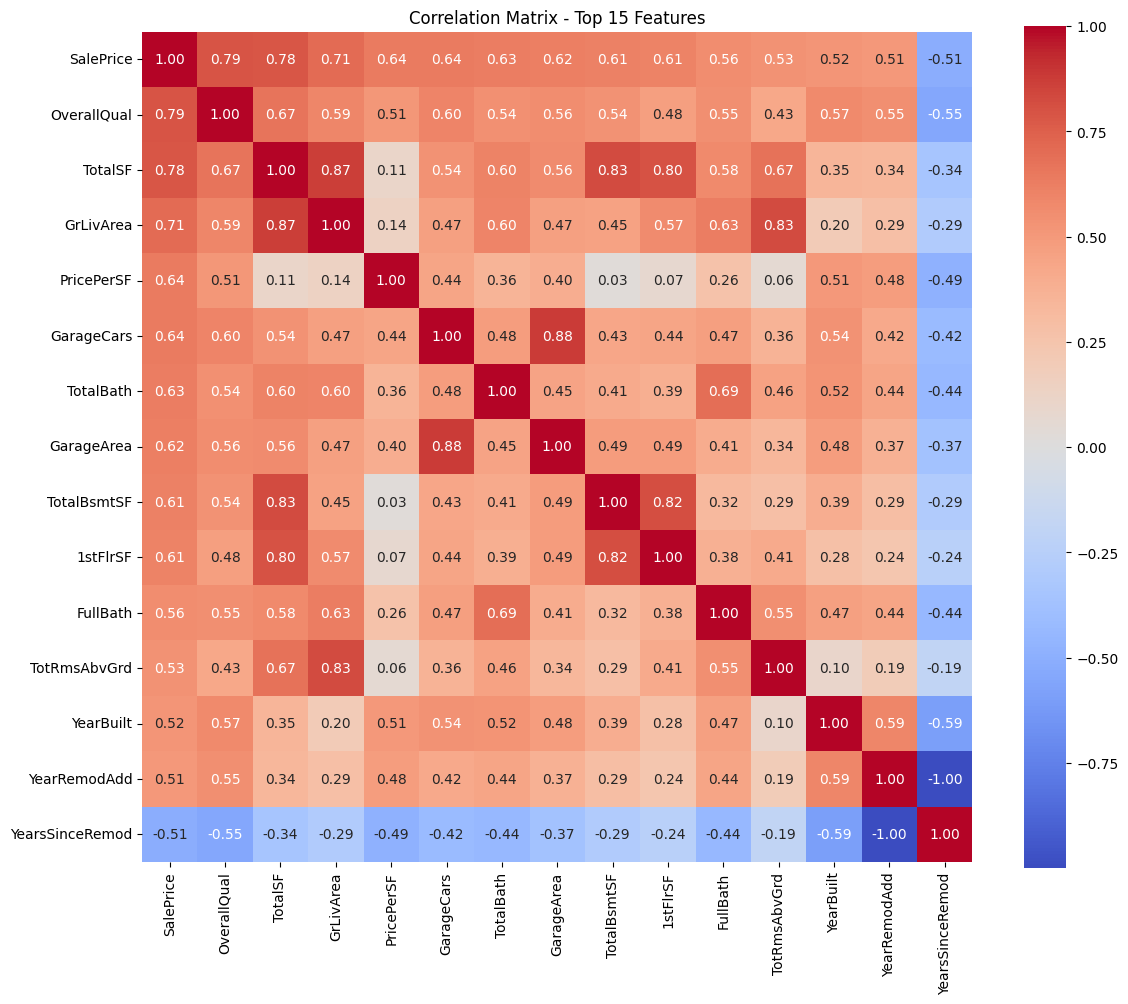


MODEL TRAINING AND VALIDATION
Training set size: 1168
Validation set size: 292
Model Performance:
RMSE: $13,301.99
R² Score: 0.9769

PREDICTION VISUALIZATION


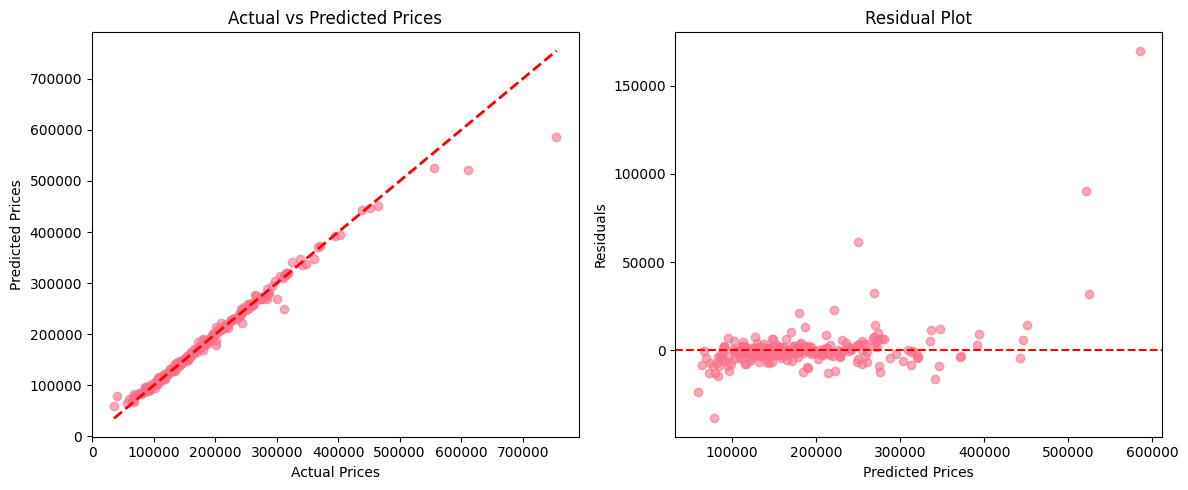


FINAL TEST PREDICTIONS
Submission file created: submission.csv

PROJECT SUMMARY

    DATA PREPROCESSING COMPLETED:
   - Loaded 1460 training samples and 1459 test samples
   - Handled missing values systematically
   - Created 11 new features
   - Encoded categorical variables
   - Scaled numerical features


📊 KEY INSIGHTS:
   - Most important features: TotalSF, OverallQual, PricePerSF, YearBuilt, TotalBath
   - Features with highest correlation to price: SalePrice, OverallQual, TotalSF, GrLivArea, PricePerSF


CONGRATULATIONS! YOUR HOUSE PRICE PREDICTION MODEL IS READY!


In [21]:
# Feature Engineering

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

def create_new_features(df):
    """Create new features from existing ones"""
    
    print("Creating new features...")
    
    # Total square footage
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    # Total bathrooms
    df['TotalBath'] = df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])
    
    # Total porch area
    df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    
    # House age
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    
    # Years since remodeling
    df['YearsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
    
    # Garage age
    df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
    df['GarageAge'] = df['GarageAge'].fillna(0)
    
    # Has pool
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    
    # Has garage
    df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    
    # Has basement
    df['HasBasement'] = (df['TotalBsmtSF'] > 0).astype(int)
    
    # Has fireplace
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    
    # Price per square foot (only for training data)
    if 'SalePrice' in df.columns:
        df['PricePerSF'] = df['SalePrice'] / df['TotalSF']
    
    return df

# Apply feature engineering
combined_data = create_new_features(combined_data)

print(f"New features created. Dataset shape: {combined_data.shape}")

# ENCODE CATEGORICAL VARIABLES


print("\n" + "="*50)
print("ENCODING CATEGORICAL VARIABLES")
print("="*50)

def encode_categorical_features(df):
    """Encode categorical variables"""
    
    print("Encoding categorical variables...")
    
    # Get categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Remove Id column if present
    if 'Id' in categorical_cols:
        categorical_cols.remove('Id')
    
    print(f"Categorical columns to encode: {len(categorical_cols)}")
    
    # Label encoding for categorical variables
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    
    return df

# Apply categorical encoding
combined_data = encode_categorical_features(combined_data)

print(f"Categorical encoding completed. Dataset shape: {combined_data.shape}")

# FEATURE SCALING

print("\n" + "="*50)
print("FEATURE SCALING")
print("="*50)

# Separate train and test data
train_processed = combined_data[:train_len].copy()
test_processed = combined_data[train_len:].copy()

# Remove target variable from test data (it's NaN anyway)
test_processed = test_processed.drop('SalePrice', axis=1)

print(f"Processed training data shape: {train_processed.shape}")
print(f"Processed test data shape: {test_processed.shape}")

# Prepare features and target
X = train_processed.drop(['SalePrice', 'Id'], axis=1)
y = train_processed['SalePrice']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"Features scaled. Final feature set shape: {X_scaled.shape}")

# =============================================================================
# STEP 11: FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Train a random forest to get feature importance
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_temp.fit(X_scaled, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_scaled.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 most important features:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# CORRELATION ANALYSIS


print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Calculate correlation with target variable
correlation = train_processed.corr()['SalePrice'].sort_values(ascending=False)
high_corr_features = correlation[abs(correlation) > 0.5]

print("Features with high correlation (>0.5) with SalePrice:")
print(high_corr_features)

# Plot correlation heatmap for top features
plt.figure(figsize=(12, 10))
top_corr_features = high_corr_features.index[:15]
corr_matrix = train_processed[top_corr_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Correlation Matrix - Top 15 Features')
plt.tight_layout()
plt.show()


# TRAIN-TEST SPLIT AND MODEL VALIDATION


print("\n" + "="*50)
print("MODEL TRAINING AND VALIDATION")
print("="*50)

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Train a Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_val)

# Calculate metrics
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"Model Performance:")
print(f"RMSE: ${rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

 #VISUALIZE PREDICTIONS

print("\n" + "="*50)
print("PREDICTION VISUALIZATION")
print("="*50)

# Plot actual vs predicted values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')

plt.subplot(1, 2, 2)
residuals = y_val - y_pred
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

#  PREPARE FINAL TEST PREDICTIONS


print("\n" + "="*50)
print("FINAL TEST PREDICTIONS")
print("="*50)

# Prepare test data
test_features = test_processed.drop('Id', axis=1)
test_scaled = scaler.transform(test_features)
test_scaled = pd.DataFrame(test_scaled, columns=test_features.columns)

# Make predictions on test data
test_predictions = rf_model.predict(test_scaled)

# Create submission file
submission = pd.DataFrame({
    'Id': test_processed['Id'],
    'SalePrice': test_predictions
})

# Save submission file
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

#  SUMMARY AND NEXT STEPS


print("\n" + "="*60)
print("PROJECT SUMMARY")
print("="*60)

print(f"""
    DATA PREPROCESSING COMPLETED:
   - Loaded {train_data.shape[0]} training samples and {test_data.shape[0]} test samples
   - Handled missing values systematically
   - Created {combined_data.shape[1] - train_data.shape[1]} new features
   - Encoded categorical variables
   - Scaled numerical features
    

📊 KEY INSIGHTS:
   - Most important features: {', '.join(feature_importance.head(5)['feature'].tolist())}
   - Features with highest correlation to price: {', '.join(high_corr_features.head(5).index.tolist())}
""")

print("\n" + "="*60)
print("CONGRATULATIONS! YOUR HOUSE PRICE PREDICTION MODEL IS READY!")
print("="*60)